# Time Series

In [2]:
import pandas as pd
import os
import sys
import mysql.connector

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

import joblib
from joblib import load, dump
import pickle
import json

In [3]:
mydb = mysql.connector.connect(
host="dbbikes.cpwzqhmscagf.eu-west-1.rds.amazonaws.com",
user="group20",
password="30830Group20",
database="dBikes"
)
query = "SELECT * FROM Bikes;"
bikes_df = pd.read_sql(query, mydb)
mydb.close()
#mycursor = mydb.cursor()

In [4]:
bikes_df.head()

,Address,Available_Bikes,Available_Stands,Updated,Status
0,Smithfield North,18,12,1646299228,OPEN
1,Parnell Square North,3,17,1646299624,OPEN
2,Clonmel Street,4,29,1646299703,OPEN
3,Avondale Road,0,35,1646299569,OPEN
4,Mount Street Lower,6,34,1646299672,OPEN


In [5]:
bikes_df.dtypes

Address             object
Available_Bikes      int64
Available_Stands     int64
Updated              int64
Status              object
dtype: object

In [6]:
bikes_df['Address'] = bikes_df['Address'].astype('category')
bikes_df['Status'] = bikes_df['Status'].astype('category')
categorical_columns = bikes_df[['Address','Status']].columns
bikes_df[categorical_columns].describe().T

,count,unique,top,freq
Address,1339583,111,Avondale Road,12154
Status,1339583,2,OPEN,1332330


In [7]:
bikes_df.dtypes

Address             category
Available_Bikes        int64
Available_Stands       int64
Updated                int64
Status              category
dtype: object

In [8]:
numeric_columns = bikes_df[['Available_Bikes','Available_Stands']].columns
bikes_df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Available_Bikes,1339583.0,12.626717,9.127229,0.0,5.0,12.0,19.0,40.0
Available_Stands,1339583.0,19.087418,10.801298,0.0,11.0,19.0,27.0,40.0


In [9]:
#changing from unix timestamp

bikes_df['Updated'] = pd.to_datetime(bikes_df['Updated'],unit='s')

In [10]:
DateTime_columns = bikes_df.select_dtypes(['datetime64[ns]']).columns
bikes_df[DateTime_columns].describe().T

/var/folders/5l/ksxk0sz53wx59mcldcmchwn40000gn/T/ipykernel_48535/4161221877.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  bikes_df[DateTime_columns].describe().T


,count,unique,top,freq,first,last
Updated,1339583,609851,2022-04-05 14:15:05,2592,2022-03-03 09:19:27,2022-04-14 14:14:14


In [11]:
bikes_df.head()

,Address,Available_Bikes,Available_Stands,Updated,Status
0,Smithfield North,18,12,2022-03-03 09:20:28,OPEN
1,Parnell Square North,3,17,2022-03-03 09:27:04,OPEN
2,Clonmel Street,4,29,2022-03-03 09:28:23,OPEN
3,Avondale Road,0,35,2022-03-03 09:26:09,OPEN
4,Mount Street Lower,6,34,2022-03-03 09:27:52,OPEN


The user will be able to see the expected number of bikes for their chosen station by inputting a date and time in the future. Therefore, the day of the week and the hour has been extracted from the 'Updated' column.

In [12]:
#column for hour of the day

bikes_df['hour_of_day'] = bikes_df['Updated'].dt.hour
bikes_df.head()

,Address,Available_Bikes,Available_Stands,Updated,Status,hour_of_day
0,Smithfield North,18,12,2022-03-03 09:20:28,OPEN,9
1,Parnell Square North,3,17,2022-03-03 09:27:04,OPEN,9
2,Clonmel Street,4,29,2022-03-03 09:28:23,OPEN,9
3,Avondale Road,0,35,2022-03-03 09:26:09,OPEN,9
4,Mount Street Lower,6,34,2022-03-03 09:27:52,OPEN,9


In [13]:
#getting column for the day of week

bikes_df['day_of_week'] = bikes_df['Updated'].dt.dayofweek


bikes_df.head()

,Address,Available_Bikes,Available_Stands,Updated,Status,hour_of_day,day_of_week
0,Smithfield North,18,12,2022-03-03 09:20:28,OPEN,9,3
1,Parnell Square North,3,17,2022-03-03 09:27:04,OPEN,9,3
2,Clonmel Street,4,29,2022-03-03 09:28:23,OPEN,9,3
3,Avondale Road,0,35,2022-03-03 09:26:09,OPEN,9,3
4,Mount Street Lower,6,34,2022-03-03 09:27:52,OPEN,9,3


In [14]:
categorical_columns = bikes_df[['Address']].columns

continuous_columns = bikes_df[['Available_Bikes', 'Available_Stands', 'hour_of_day', 'day_of_week']].columns

bikes_df[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Available_Bikes,1339583.0,12.626717,9.127229,0.0,5.0,12.0,19.0,40.0
Available_Stands,1339583.0,19.087418,10.801298,0.0,11.0,19.0,27.0,40.0
hour_of_day,1339583.0,11.510155,6.889129,0.0,6.0,12.0,17.0,23.0
day_of_week,1339583.0,2.995581,1.995828,0.0,1.0,3.0,5.0,6.0


In [15]:
bikes_df[categorical_columns].describe().T

,count,unique,top,freq
Address,1339583,111,Avondale Road,12154


In [16]:
bikes_df.head()

,Address,Available_Bikes,Available_Stands,Updated,Status,hour_of_day,day_of_week
0,Smithfield North,18,12,2022-03-03 09:20:28,OPEN,9,3
1,Parnell Square North,3,17,2022-03-03 09:27:04,OPEN,9,3
2,Clonmel Street,4,29,2022-03-03 09:28:23,OPEN,9,3
3,Avondale Road,0,35,2022-03-03 09:26:09,OPEN,9,3
4,Mount Street Lower,6,34,2022-03-03 09:27:52,OPEN,9,3


In [17]:
bikes_df['Week_Number'] = bikes_df['Updated'].dt.week
bikes_df.head()

/var/folders/5l/ksxk0sz53wx59mcldcmchwn40000gn/T/ipykernel_48535/2022165023.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  bikes_df['Week_Number'] = bikes_df['Updated'].dt.week


,Address,Available_Bikes,Available_Stands,Updated,Status,hour_of_day,day_of_week,Week_Number
0,Smithfield North,18,12,2022-03-03 09:20:28,OPEN,9,3,9
1,Parnell Square North,3,17,2022-03-03 09:27:04,OPEN,9,3,9
2,Clonmel Street,4,29,2022-03-03 09:28:23,OPEN,9,3,9
3,Avondale Road,0,35,2022-03-03 09:26:09,OPEN,9,3,9
4,Mount Street Lower,6,34,2022-03-03 09:27:52,OPEN,9,3,9


In [18]:
bikes_df["Week_Number"].unique()

array([ 9, 10, 11, 12, 13, 14, 15])

Picking three station at random, will look at the time series for number of bikes available over the week.

In [19]:
week_number_10 = bikes_df[(bikes_df['Week_Number'] == 10)]

week_number_10

,Address,Available_Bikes,Available_Stands,Updated,Status,hour_of_day,day_of_week,Week_Number
114290,Smithfield North,27,3,2022-03-07 00:01:56,OPEN,0,0,10
114291,Parnell Square North,0,20,2022-03-07 00:03:58,OPEN,0,0,10
114292,Clonmel Street,14,19,2022-03-07 00:02:44,OPEN,0,0,10
114295,Christchurch Place,8,12,2022-03-07 00:01:29,OPEN,0,0,10
114296,Grantham Street,25,5,2022-03-07 00:01:38,OPEN,0,0,10
...,...,...,...,...,...,...,...,...
336172,Parnell Street,10,9,2022-03-13 23:59:45,OPEN,23,6,10
336181,Benson Street,3,37,2022-03-13 23:59:46,OPEN,23,6,10
336186,John Street West,15,16,2022-03-13 23:59:28,OPEN,23,6,10
336196,Charlemont Street,3,37,2022-03-13 23:59:44,OPEN,23,6,10


In [61]:
Earls_ = week_number_10[(week_number_10['Address'] == "Earlsfort Terrace")]

In [21]:
Earls_tue = Earls_[(Earls_['day_of_week'] == 2)]

Text(0.5, 1.0, 'Earlsforth Terrace Station on Wednesday, 9th of March')

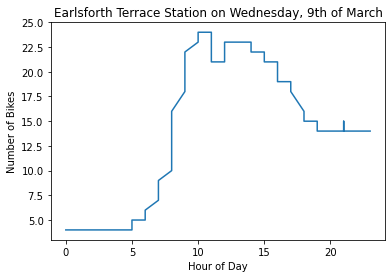

In [26]:
plt.plot(Earls_tue["hour_of_day"],Earls_tue["Available_Bikes"])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Bikes')
plt.title('Earlsforth Terrace Station on Wednesday, 9th of March')

In [56]:
time = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [57]:
predictor_list = []

for x in time:

    model = load('Earlsfort Terrace_model.pkl')
    bike_avail_predict = model.predict([[x, 2]])

    predict_list = bike_avail_predict.tolist()
    predict_dict = {"bikes": predict_list[0]}
    predictor_list.append(round(predict_list[0], 0))
    result = json.dumps(predict_dict)

    #print(result)

/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: 

In [58]:
print(predictor_list)

[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 8.0, 13.0, 18.0, 18.0, 19.0, 19.0, 18.0, 17.0, 15.0, 12.0, 11.0, 9.0, 8.0, 8.0, 8.0, 6.0, 6.0]


Text(0.5, 1.0, 'Earlsforth Terrace Station Prediction for different times on a Wednesday')

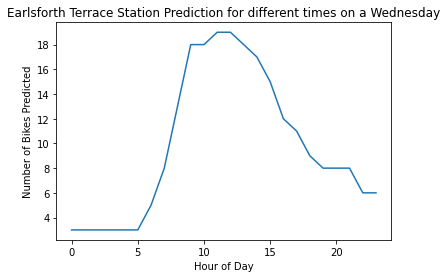

In [60]:
plt.plot(time, predictor_list)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Bikes Predicted')
plt.title('Earlsforth Terrace Station Prediction for different times on a Wednesday')

Checking another Station: 

In [63]:
Grange = week_number_10[(week_number_10['Address'] == "Grangegorman Lower (South)")]

In [71]:
Grange_Thur = Grange[(Grange['day_of_week'] == 3)]

Text(0.5, 1.0, 'Grangegorman Lower (South) Station on Thursday, 10th of March')

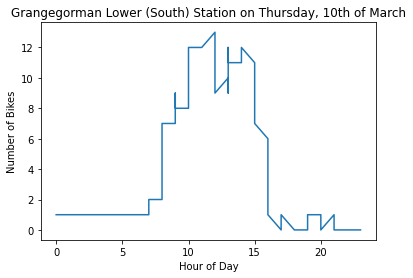

In [100]:
plt.plot(Grange_Thur["hour_of_day"],Grange_Thur["Available_Bikes"])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Bikes')
plt.title('Grangegorman Lower (South) Station on Thursday, 10th of March')

In [97]:
predictor_list = []

for x in time:

    model = load('Grangegorman Lower (South)_model.pkl')
    bike_avail_predict = model.predict([[x, 2]])

    predict_list = bike_avail_predict.tolist()
    predict_dict = {"bikes": predict_list[0]}
    predictor_list.append(round(predict_list[0], 0))
    result = json.dumps(predict_dict)

    #print(result)

/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: 

Text(0.5, 1.0, 'Grangegorman Lower (South) Prediction for different times on a Thursday')

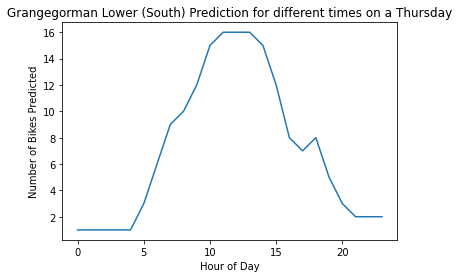

In [99]:
plt.plot(time, predictor_list)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Bikes Predicted')
plt.title('Grangegorman Lower (South) Prediction for different times on a Thursday')

Checking a weekend:

In [92]:
Broadstone_Street = week_number_10[(week_number_10['Address'] == "Broadstone")]

In [93]:
Broadstone_Sat = Market_Street[(Market_Street['day_of_week'] == 5)]

Text(0.5, 1.0, 'Broadstone on Saturday, 12th of March')

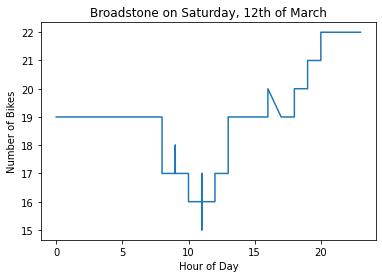

In [94]:
plt.plot(Market_Sat["hour_of_day"],Market_Sat["Available_Bikes"])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Bikes')
plt.title('Broadstone on Saturday, 12th of March')

In [90]:
predictor_list = []

for x in time:

    model = load('Broadstone_model.pkl')
    bike_avail_predict = model.predict([[x, 2]])

    predict_list = bike_avail_predict.tolist()
    predict_dict = {"bikes": predict_list[0]}
    predictor_list.append(round(predict_list[0], 0))
    result = json.dumps(predict_dict)

    #print(result)

/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/conorkennedy/opt/miniconda3/envs/comp30830/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: 

Text(0.5, 1.0, 'Broadstone Station prediction for a Saturday')

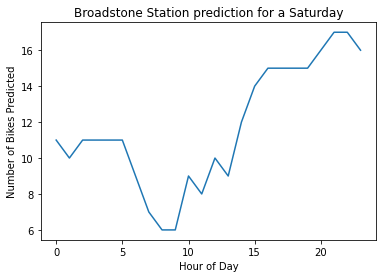

In [95]:
plt.plot(time, predictor_list)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Bikes Predicted')
plt.title('Broadstone Station prediction for a Saturday')